In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
# Add Python Tools
pythonToolsDir = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\PythonTools'
sys.path.append(pythonToolsDir)

# Add ctk-cli
ctkcli_DIR = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\ctk-cli'
sys.path.append(ctkcli_DIR)

# Add TrabeculaeTools
TrabeculaeTools_DIR = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TrabeculaeTools'
sys.path.append(TrabeculaeTools_DIR)

from ImageJTools import macroImageJ
from ImageJTools.HelperBoneJ import joinBoneJResults, extractSquareRoIs, maskImage, randomTransformation

from PythonTools import registration, transforms, transformations
from PythonTools.helpers import vtk as vtkhelper

import vtk
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import os
import time


## Interpolation Vs BoneJ metrics

 This script use a RoI from uCT image that will be transformed by a random
 rigid transformation in order to accumulate interpolation error.
 Resulting images will be analyzed using BoneJ and metric will be
 extracted and compared to the original image ones.

 If there is no difference between transformed/wrapped images and original
 one, we could assure that interpolation has no noticeable effect on 
 BoneJ metrics.

In [6]:
## Data for testing

imagePath = r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TestingData\uCT.nii'
boneMaskPath = r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TestingData\uCT_BoneMask.nii'

Reading image...
Elapsed time: [ 2.24699997902 ] sec
Reading mask...
Elapsed time: [ 4.44800019264 ] sec
Downsampling mask...
Elapsed time: [ 4.45200014114 ] sec
Eroding mask...
Elapsed time: [ 4.5150001049 ] sec
Upsampling mask...
Elapsed time: [ 4.72800016403 ] sec
Saving result mask...
Elapsed time: [ 15.4050002098 ] sec
TOTAL elapsed time: [ 15.6270000935 ] sec


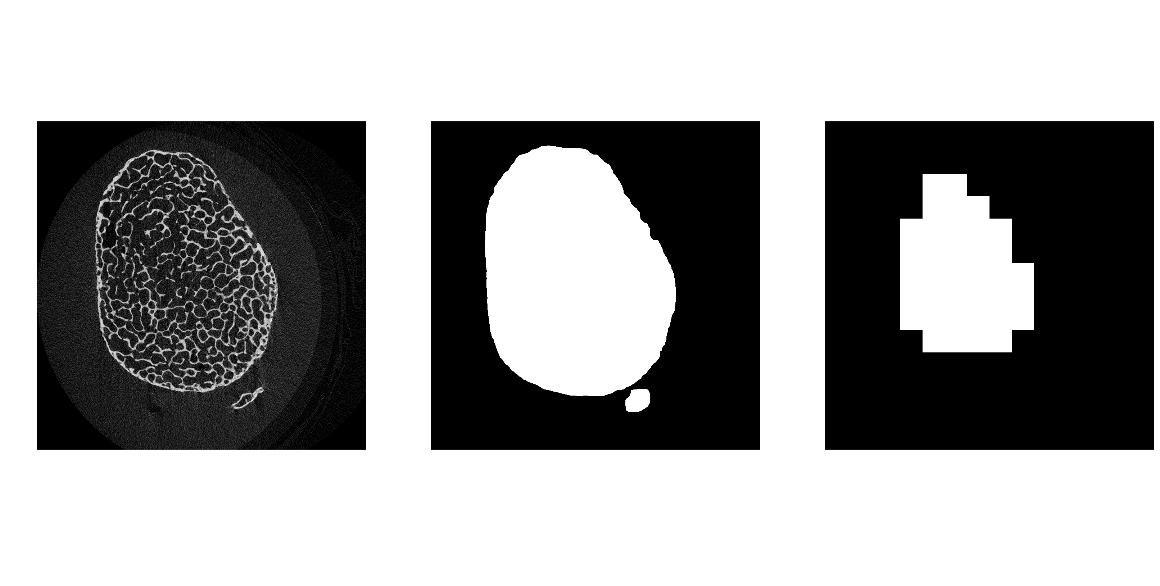

In [26]:
# 0. Load image and mask

import time

start = time.time()

# Read image
print "Reading image..."
vtkReader = vtk.vtkNIFTIImageReader()
vtkReader.SetFileName(imagePath)
vtkReader.Update()
image = vtkhelper.ImageData_to_array(vtkReader.GetOutput())
print "Elapsed time: [", time.time() - start, "] sec"

# Read mask
print "Reading mask..."
vtkReader.SetFileName(boneMaskPath)
vtkReader.Update()
mask = vtkhelper.ImageData_to_array(vtkReader.GetOutput())
print "Elapsed time: [", time.time() - start, "] sec"

RoiSize = 125 # 3.5 mm aprox

# Resample image mask
print "Downsampling mask..."
downsamplingFactor = ( RoiSize - 1 ) / 2.0
vtkReslicer = vtk.vtkImageReslice()
vtkReslicer.SetInputConnection( vtkReader.GetOutputPort() )
newSpacing =  downsamplingFactor * np.array([vtkReader.GetOutput().GetSpacing()[0],\
                                                             vtkReader.GetOutput().GetSpacing()[1],\
                                                             vtkReader.GetOutput().GetSpacing()[2]])
vtkReslicer.SetOutputSpacing( newSpacing[0], newSpacing[1], newSpacing[2])
vtkReslicer.SetInterpolationModeToNearestNeighbor()
vtkReslicer.Update()
print "Elapsed time: [", time.time() - start, "] sec"


# Eroding mask
print "Eroding mask..."
vtkEroder = vtk.vtkImageContinuousErode3D();
vtkEroder.SetInputConnection(vtkReslicer.GetOutputPort())
vtkEroder.SetKernelSize(3, 3,3 );
vtkEroder.Update()

print "Elapsed time: [", time.time() - start, "] sec"

# Resample image mask
print "Upsampling mask..."
vtkReslicer = vtk.vtkImageReslice()
vtkReslicer.SetInputConnection( vtkEroder.GetOutputPort() )
vtkReslicer.SetOutputExtent(vtkReader.GetOutput().GetExtent())
newSpacing =  np.array([vtkReader.GetOutput().GetSpacing()[0],\
                                             vtkReader.GetOutput().GetSpacing()[1],\
                                             vtkReader.GetOutput().GetSpacing()[2]])
vtkReslicer.SetOutputSpacing( newSpacing[0], newSpacing[1], newSpacing[2])
vtkReslicer.SetInterpolationModeToNearestNeighbor()
vtkReslicer.Update()
erodedMask = vtkhelper.ImageData_to_array(vtkReslicer.GetOutput())
print "Elapsed time: [", time.time() - start, "] sec"

# Saving new mask
print "Saving result mask..."
vtkWriter = vtk.vtkNIFTIImageWriter()
vtkWriter.SetFileName(r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TestingData\uCT_BoneMask_erode.nii')
vtkWriter.SetInputConnection(vtkReslicer.GetOutputPort())
vtkWriter.Write()
vtkWriter.Update()
print "Elapsed time: [", time.time() - start, "] sec"



f, axarr = plt.subplots(1,3, sharex = True,figsize=(20,10))
axarr[0].imshow(image[500,:,:], cmap = matplotlib.cm.Greys_r);
axarr[0].axis('off');
axarr[1].imshow(mask[500,:,:], cmap = matplotlib.cm.Greys_r);
axarr[1].axis('off');
axarr[2].imshow(erodedMask[500,:,:], cmap = matplotlib.cm.Greys_r);
axarr[2].axis('off');
print "TOTAL elapsed time: [", time.time() - start, "] sec"

In [10]:
##########################################
#              PARAMETERS               ##
##########################################
NRandomRoIs = 10
NTransform = 10
sizeRoImmVector = [5,6,7,3]
RandomSeed = 1


imagePath = r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\uCTWrappingStudy\ImagesForAnalysis\uCT.nii'
boneMaskPath = r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\uCTWrappingStudy\ImagesForAnalysis\uCT_BoneMask.nii'
pathToSaveDirMain = r'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\uCTWrappingStudy'

imagej_exe_path = r'C:\c_users\marinetto\Projects\BoneMorpho\Software_doc\Fiji.app\ImageJ-win64.exe'

# Macro definition
fileXMLdescription = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.xml'
macroPath = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.ijm'
segmentTrabecula = macroImageJ(imagejPath = imagej_exe_path, macroPath = macroPath, xmlDefinition = fileXMLdescription)

# Macro definition
fileXMLdescription = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.xml'
macroPath = u'J:\Projects\BoneMorpho\Development\TrabeculaeSoftware\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.ijm'
BoneJMetrics = macroImageJ(imagejPath = imagej_exe_path, macroPath = macroPath, xmlDefinition = fileXMLdescription)

In [19]:
# This could be run in parallel for each sizeRoImm.

totalProcess = time.time()
totalOfProcessings = len(sizeRoImmVector) * NRandomRoIs * NTransform
currentProcess = 0

# For each size RoI studied
for sizeRoImm in sizeRoImmVector:
    
    print "Current Analysis"
    print "    - Roi Size (mm):                    ", sizeRoImm
    print "    - Number of random RoIs:            ", NRandomRoIs
    print "    - Number of random Transformations: ", NTransform
    
    # 1. Generate NRandomRoIs from the mask
    RoIfileStructure = extractSquareRoIs( boneMaskPath, sizeRoImm, pathToSaveDirMain + r'\roiFiles', NRandomRoIs )

    # Folder for RoI results
    pathToSaveDir = pathToSaveDirMain + '\\RoI_' + str(sizeRoImm) + 'mm'
    if not os.path.exists(pathToSaveDir):
        os.makedirs(pathToSaveDir)

    # For each Random generated RoI of this size
    for i in range(RoIfileStructure.shape[0]):
        
        # Get the Roi parameters
        currentRoIparameters = RoIfileStructure[i]
        
        # Define the filename for the Segmented image
        roiFileName = imagePath.split("\\")[-1][:-4] + '_Roi_' + str(currentRoIparameters[4]) + '_mm_' + str(currentRoIparameters[0]) + '.nii'
        
        # Define the complete path for saving and create folder for saving results
        pathToSaveRoIImages = pathToSaveDir + '\\GeneratedRoIImages'
        if not os.path.exists(pathToSaveRoIImages):
            os.makedirs(pathToSaveRoIImages)

        roiImageFilepath = pathToSaveRoIImages + '\\' + roiFileName
        maskImage(imagePath, currentRoIparameters, roiImageFilepath)

        # For each random RoI image generate random Transformations
        pathToSaveTransforms = pathToSaveDir + '\\Transforms'
        if not os.path.exists(pathToSaveTransforms):
            os.makedirs(pathToSaveTransforms)

        # For each Transformation
        for j in range(NTransform):
              
            
            TNumber = j
            
            # Transform the image
            transformedImage = randomTransformation(roiImageFilepath,pathToSaveTransforms,TNumber)
            
            # Segment trabeculae using BoneJ algorithm (very used in several papers)
            transformedImageSegmentedTrabecula = transformedImage[:-4:] + '_trabeculae.tif'
            segmentTrabecula.runMacro(SMOOTH_Sigma = 0.03,\
                                      TH_Erosion = 0,\
                                      TH_Dilation = 0,\
                                      inputImage = transformedImage,\
                                      outputImage = transformedImageSegmentedTrabecula)


            # Macro launch analysis of metrics
            outputDir = transformedImageSegmentedTrabecula[:-4:]
            if not os.path.exists(outputDir):
                os.makedirs(outputDir)

            ## IMPORTANT make sure that centroid < radius. This is important for Anisotropy analysis of the current size RoI
            # ANISOTROPY_Radius < sizeRoImm
            pANISOTROPY_Radius = 0.9 * sizeRoImm/2.0;


            params = BoneJMetrics.runMacro( inputImage = transformedImageSegmentedTrabecula,\
                                            outputDir = outputDir,\
                                            ANISOTROPY_Radius = pANISOTROPY_Radius)

            resultsJoinedFile = pathToSaveDirMain + '\TotalResults'
            if not os.path.exists(resultsJoinedFile):
                os.makedirs(resultsJoinedFile)
            
            # Join all results under same file of results for this case
            resultsJoinedFile = resultsJoinedFile + '\Results_Roi_' + str(sizeRoImm) + '_mm_N_' + str(i) + '_Tf_' + str(j) + '.csv'

            joinBoneJResults(resultsPath = outputDir, \
                     resultsJoinedFile = resultsJoinedFile, \
                     imageName = 'RoiNum.' + str(i) + 'Tf.' + str(j), 
                     roiName = 'RoI.' + str(sizeRoImm) + '.mm', \
                     roiSizeX = sizeRoImm, \
                     roiSizeY = sizeRoImm, \
                     roiSizeZ = sizeRoImm,
                     parameters = params)
            
            currentProcess = currentProcess + 1
            currentPercentage = ( (1.0 * currentProcess) / totalOfProcessings) * 100.0
            print "[{0:.2f} s]".format(time.time() - totalProcess) + " - [",  currentPercentage,"] %"

print "TOTAL elapsed time:[{0:.2f} s]".format(time.time() - totalProcess)

Current Analysis
    - Roi Size (mm):                     5
    - Number of random RoIs:             10
    - Number of random Transformations:  10
[392.07 s] - [ 0.25 ] %
[776.95 s] - [ 0.5 ] %
[1128.10 s] - [ 0.75 ] %
[1450.35 s] - [ 1.0 ] %
[1818.15 s] - [ 1.25 ] %
[2201.82 s] - [ 1.5 ] %
[2595.86 s] - [ 1.75 ] %
[2942.75 s] - [ 2.0 ] %
[3318.02 s] - [ 2.25 ] %
[3644.00 s] - [ 2.5 ] %
[4010.67 s] - [ 2.75 ] %
[4348.29 s] - [ 3.0 ] %
[4748.24 s] - [ 3.25 ] %
[5091.47 s] - [ 3.5 ] %
[5470.47 s] - [ 3.75 ] %
[5814.39 s] - [ 4.0 ] %
[6151.19 s] - [ 4.25 ] %
[6558.91 s] - [ 4.5 ] %
[6930.13 s] - [ 4.75 ] %
[7287.98 s] - [ 5.0 ] %
[7622.28 s] - [ 5.25 ] %
[7982.34 s] - [ 5.5 ] %
[8341.32 s] - [ 5.75 ] %
[8660.57 s] - [ 6.0 ] %
[9015.84 s] - [ 6.25 ] %
[9382.17 s] - [ 6.5 ] %
[9738.14 s] - [ 6.75 ] %
[10111.95 s] - [ 7.0 ] %
[10465.82 s] - [ 7.25 ] %
[10802.14 s] - [ 7.5 ] %
[11155.98 s] - [ 7.75 ] %
[11544.05 s] - [ 8.0 ] %
[11935.25 s] - [ 8.25 ] %
[12326.24 s] - [ 8.5 ] %
[12668.45 s] -

AttributeError: 'NoneType' object has no attribute 'shape'

    ## Debugging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.00 s]    - Reading mask...
[1.58 s]    - Calculating RoI voxel size:  [ 179.  179.  179.]
[1.58 s]    - Downsampling mask...
[1.58 s]    - Downsampling factor [{0:.2f}] [ 0.00558659  0.00558659  0.00558659]
[1.64 s]    - New spacing [ 5.00841829  5.00842196  5.00842229]


array([[   0.,  292.,  330.,  490.,    3.,    0.],
       [   1.,  312.,  185.,  284.,    3.,    0.],
       [   2.,  259.,  584.,  292.,    3.,    0.],
       [   3.,  470.,  576.,  353.,    3.,    0.],
       [   4.,  265.,  261.,  281.,    3.,    0.],
       [   5.,  539.,  162.,  425.,    3.,    0.],
       [   6.,  308.,  317.,  560.,    3.,    0.],
       [   7.,  367.,  140.,  252.,    3.,    0.],
       [   8.,  425.,  566.,  453.,    3.,    0.],
       [   9.,  317.,  306.,  410.,    3.,    0.]])